In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.model_selection import train_test_split

from fairness_measures import *

df = pd.read_csv("all_vals_race1_interestrate1.csv")


df.drop(
    columns=[
        "IsTestData",
        "IsCalibrateData",
        "v1",
        "istestdata2",
        "iscalibratedata2",
    ],
    inplace=True,
)

df["minority"] = (
    (df["race_dum_Black"] == 1)
    | (df["race_dum_Native Am, Alaska, Hawaii"] == 1)
    | (df["race_dum_White hisp"] == 1)
    # | (df['race_dum_Asian'] == 1)
)

features = df.drop(
    columns=[
        "default", "minority", 'default_age', 'prepayment', 
        # "log_org_amt",
        # 'orig_amt', 'fico_orig_miss', 'income_miss',
        # 'document_type_dum_1', 'document_type_dum_2', 'document_type_dum_3',
        # 'loan_purpose_dum_1', 'orig_year_dum_2018',
        "race_dum_Unknown", "race_dum_Asian", "race_dum_Black",
        "race_dum_Native Am, Alaska, Hawaii", "race_dum_White hisp", "race_dum_White non-hisp"
    ],
    axis=1
)

target = df["default"]

features_numeric = pd.get_dummies(features, drop_first=True)

sensitive_features = df["minority"]

In [10]:
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val, sensitive_train, sensitive_val = train_test_split(
    features_numeric, target, sensitive_features, test_size=0.1, random_state=42
)

scaler = StandardScaler()
X_train = pd.DataFrame(
    scaler.fit_transform(X_train), columns=features_numeric.columns, index=X_train.index
)

X_train = X_train.dropna()
y_train = y_train[X_train.index]

X_val = X_val.dropna()
y_val = y_val[X_val.index]

Confusion Matrix:
 [[120061     73]
 [  7987     43]]


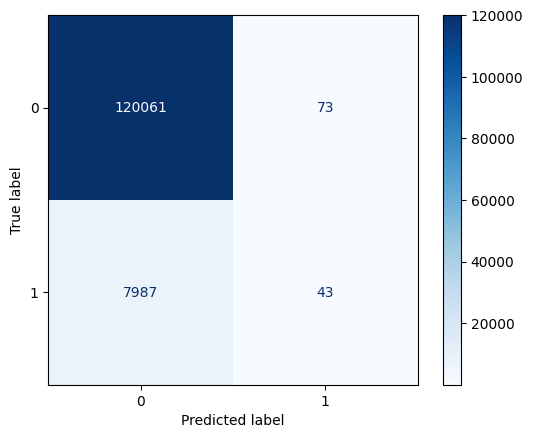

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Scale validation data using same scaler
X_val = pd.DataFrame(scaler.transform(X_val), columns=features_numeric.columns, index=X_val.index)

# Predict
y_pred = clf.predict(X_val)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

print("Confusion Matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

In [12]:
print(np.any(np.isnan(X_train)), np.any(np.isnan(X_val)))
print(np.any(np.isinf(X_train)), np.any(np.isinf(X_val)))

False False
False False


c:\Users\bencu\anaconda3\envs\tf210gpu\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\bencu\anaconda3\envs\tf210gpu\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Epoch 1/20
8438/8438 [==============================] - 131s 15ms/step - loss: 0.8913 - accuracy: 0.6252 - auc: 0.7748 - val_loss: 292589.5625 - val_accuracy: 0.8872 - val_auc: 0.5176
Epoch 2/20
8438/8438 [==============================] - 119s 14ms/step - loss: 0.7180 - accuracy: 0.6307 - auc: 0.8222 - val_loss: 299871.7188 - val_accuracy: 0.9111 - val_auc: 0.5080
Epoch 3/20
8438/8438 [==============================] - 122s 14ms/step - loss: 0.7055 - accuracy: 0.6386 - auc: 0.8259 - val_loss: 356843.8438 - val_accuracy: 0.9119 - val_auc: 0.5082
Epoch 4/20
8438/8438 [==============================] - 218s 26ms/step - loss: 0.6979 - accuracy: 0.6446 - auc: 0.8278 - val_loss: 402393.1562 - val_accuracy: 0.9129 - val_auc: 0.5080
Epoch 5/20
8438/8438 [==============================] - 223s 26ms/step - loss: 0.6918 - accuracy: 0.6492 - auc: 0.8290 - val_loss: 494928.9688 - val_accuracy: 0.9364 - val_auc: 0.5002
Epoch 6/20
4006/4006 [==============================] - 14s 4ms/step
Optimal Thr

c:\Users\bencu\anaconda3\envs\tf210gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bencu\anaconda3\envs\tf210gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bencu\anaconda3\envs\tf210gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

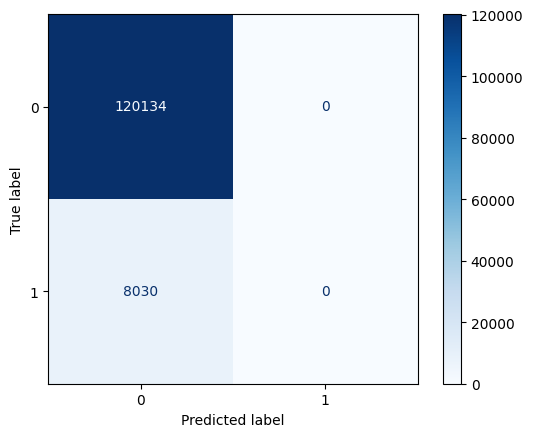

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -----------------------------
# 1. Oversample minority class
# -----------------------------
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# -----------------------------
# 2. Scale validation data
# -----------------------------
X_val = pd.DataFrame(scaler.transform(X_val), columns=features_numeric.columns, index=X_val.index)

# -----------------------------
# 3. Build the model
# -----------------------------
model = models.Sequential(
    [
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(32, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(1, activation="sigmoid"),
    ]
)

# -----------------------------
# 4. Compile model
# -----------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")],
)

# -----------------------------
# 5. Compute class weights
# -----------------------------
classes = np.unique(y_train)
weights = compute_class_weight("balanced", classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))

# -----------------------------
# 6. Early stopping
# -----------------------------
early_stop = callbacks.EarlyStopping(
    monitor="val_auc", patience=5, restore_best_weights=True, mode="max"
)

# -----------------------------
# 7. Train model
# -----------------------------
history = model.fit(
    X_train_res,
    y_train_res,
    epochs=20,
    batch_size=256,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stop],
)

# -----------------------------
# 8. Predict probabilities
# -----------------------------
y_pred_probs = model.predict(X_val)

# -----------------------------
# 9. Choose optimal threshold using ROC curve
# -----------------------------
fpr, tpr, thresholds = roc_curve(y_val, y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

# -----------------------------
# 10. Apply threshold
# -----------------------------
y_pred_opt = (y_pred_probs > optimal_threshold).astype(int).flatten()

# -----------------------------
# 11. Confusion matrix and report
# -----------------------------
cm = confusion_matrix(y_val, y_pred_opt)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n", classification_report(y_val, y_pred_opt))

# -----------------------------
# 12. Plot confusion matrix
# -----------------------------
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.show()